# Carregamento dos dados

TO DO: 
- Checar como funciona a separação de dados de validação e dados de teste;  
- Checar maneiras de conseguir melhorar o desempenho dos modelos;  
- Aplicar o MinMaxScaler nas funções de ML;  
- Aprender a usar não apenas os parametros hard coded na função.

In [105]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif

from imblearn.over_sampling import SMOTE
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
df1 = pd.read_csv('State_of_data_2022.csv')
df1.shape

(4271, 353)

In [3]:
df1.head()

,"('P0', 'id')","('P1_a ', 'Idade')","('P1_a_1 ', 'Faixa idade')","('P1_b ', 'Genero')","('P1_c ', 'Cor/raca/etnia')","('P1_d ', 'PCD')","('P1_e ', 'experiencia_profissional_prejudicada')","('P1_f ', 'aspectos_prejudicados')","('P1_g ', 'vive_no_brasil')","('P1_i ', 'Estado onde mora')",...,"('P8_d_2 ', 'Coletando e limpando os dados que uso para análise e modelagem.')","('P8_d_3 ', 'Entrando em contato com os times de negócio para definição do problema, identificar a solução e apresentação de resultados.')","('P8_d_4 ', 'Desenvolvendo modelos de Machine Learning com o objetivo de colocar em produção em sistemas (produtos de dados).')","('P8_d_5 ', 'Colocando modelos em produção, criando os pipelines de dados, APIs de consumo e monitoramento.')","('P8_d_6 ', 'Cuidando da manutenção de modelos de Machine Learning já em produção, atuando no monitoramento, ajustes e refatoração quando necessário.')","('P8_d_7 ', 'Realizando construções de dashboards em ferramentas de BI como PowerBI, Tableau, Looker, Qlik, etc.')","('P8_d_8 ', 'Utilizando ferramentas avançadas de estatística como SAS, SPSS, Stata etc, para realizar análises.')","('P8_d_9 ', 'Criando e dando manutenção em ETLs, DAGs e automações de pipelines de dados.')","('P8_d_10 ', 'Criando e gerenciando soluções de Feature Store e cultura de MLOps.')","('P8_d_11 ', 'Criando e mantendo a infra que meus modelos e soluções rodam (clusters, servidores, API, containers, etc.)')"
0,zzqzz3l9ily8nuo2m7wyzzqzz3w48o96,39.0,35-39,Masculino,Parda,Não,Não acredito que minha experiência profissiona...,NaN,True,Distrito Federal (DF),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,zzls2oftfn9law393oezzls2ofhvfpzd,32.0,30-34,Masculino,Parda,Não,"Sim, acredito que a minha a experiência profis...",Aprovação em processos seletivos/entrevistas,True,Pará (PA),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,zzdwqzfqqp1ypc7ps6m0hzzdwqz292yi,53.0,50-54,Masculino,Branca,Não,NaN,NaN,True,Distrito Federal (DF),...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,zzbqh3uy7yk7k9qmkzzbqtb4s9faqspl,27.0,25-29,Masculino,Branca,Não,NaN,NaN,True,Minas Gerais (MG),...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,zzaf1m95yan929rb94wzzaf1mekhvhpg,46.0,45-49,Feminino,Branca,Não,Não acredito que minha experiência profissiona...,NaN,True,Pará (PA),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Pré-Processamento dos Dados

In [4]:
df = df1.copy()

In [5]:
# Fazendo um primeiro filtro de colunas do dataframe (fiz uma análise das colunas manualmente no excel pra essa primeira seleção)
df = df[["('P1_a ', 'Idade')","('P1_a_1 ', 'Faixa idade')","('P1_b ', 'Genero')","('P1_c ', 'Cor/raca/etnia')","('P1_d ', 'PCD')","('P1_g ', 'vive_no_brasil')",
           "('P1_i_1 ', 'uf onde mora')","('P1_i_2 ', 'Regiao onde mora')","('P1_l ', 'Nivel de Ensino')","('P1_m ', 'Área de Formação')",
           "('P2_a ', 'Qual sua situação atual de trabalho?')","('P2_b ', 'Setor')","('P2_c ', 'Numero de Funcionarios')","('P2_d ', 'Gestor?')","('P2_f ', 'Cargo Atual')",
           "('P2_g ', 'Nivel')","('P2_h ', 'Faixa salarial')","('P2_i ', 'Quanto tempo de experiência na área de dados você tem?')",
           "('P2_j ', 'Quanto tempo de experiência na área de TI/Engenharia de Software você teve antes de começar a trabalhar na área de dados?')",
           "('P2_k ', 'Você está satisfeito na sua empresa atual?')","('P2_m ', 'Você participou de entrevistas de emprego nos últimos 6 meses?')",
           "('P2_n ', 'Você pretende mudar de emprego nos próximos 6 meses?')","('P2_p ', 'Atualmente qual a sua forma de trabalho?')",
           "('P2_s ', 'Sua empresa passu por Layoff em 2022?')","('P3_a ', 'Qual o número aproximado de pessoas que atuam com dados na sua empresa hoje?')",
           "('P4_a_1 ', 'Atuacao')","('P4_d ', 'Quais das linguagens listadas abaixo você utiliza no trabalho?')","('P4_d_1 ', 'SQL')","('P4_d_2 ', 'R ')",
           "('P4_d_3 ', 'Python')","('P4_d_4 ', 'C/C++/C#')","('P4_d_5 ', '.NET')","('P4_d_6 ', 'Java')","('P4_d_7 ', 'Julia')","('P4_d_8 ', 'SAS/Stata')",
           "('P4_d_9 ', 'Visual Basic/VBA')","('P4_d_10 ', 'Scala')","('P4_d_11 ', 'Matlab')","('P4_d_12 ', 'PHP')","('P4_d_13 ', 'Javascript')",
           "('P4_d_14 ', 'Não utilizo nenhuma linguagem')","('P5_c ', 'Há quanto tempo você busca uma oportunidade na área de dados?')",
]]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4271 entries, 0 to 4270
Data columns (total 42 columns):
 #   Column                                                                                                                                  Non-Null Count  Dtype  
---  ------                                                                                                                                  --------------  -----  
 0   ('P1_a ', 'Idade')                                                                                                                      4197 non-null   float64
 1   ('P1_a_1 ', 'Faixa idade')                                                                                                              4271 non-null   object 
 2   ('P1_b ', 'Genero')                                                                                                                     4262 non-null   object 
 3   ('P1_c ', 'Cor/raca/etnia')                                    

In [7]:
# Renomeando as colunas
# Função para extrair o nome da coluna dos títulos
def extract_column_name(title):
    return title.split(", ")[1][1:-2]

# Renomear as colunas
df.columns = [extract_column_name(title) for title in df.columns]

In [8]:
df.columns

Index(['Idade', 'Faixa idade', 'Genero', 'Cor/raca/etnia', 'PCD',
       'vive_no_brasil', 'uf onde mora', 'Regiao onde mora', 'Nivel de Ensino',
       'Área de Formação', 'Qual sua situação atual de trabalho?', 'Setor',
       'Numero de Funcionarios', 'Gestor?', 'Cargo Atual', 'Nivel',
       'Faixa salarial',
       'Quanto tempo de experiência na área de dados você tem?',
       'Quanto tempo de experiência na área de TI/Engenharia de Software você teve antes de começar a trabalhar na área de dados?',
       'Você está satisfeito na sua empresa atual?',
       'Você participou de entrevistas de emprego nos últimos 6 meses?',
       'Você pretende mudar de emprego nos próximos 6 meses?',
       'Atualmente qual a sua forma de trabalho?',
       'Sua empresa passu por Layoff em 2022?',
       'Qual o número aproximado de pessoas que atuam com dados na sua empresa hoje?',
       'Atuacao',
       'Quais das linguagens listadas abaixo você utiliza no trabalho?', 'SQL',
       'R ', 'P

In [9]:
# Renomeando a coluna 'target' e colocando-a na posição 1
df.rename(columns={"Faixa salarial":'target'}, inplace = True)
target = df.pop("target")
df.insert(0,'target', target)
df.head()

,target,Idade,Faixa idade,Genero,Cor/raca/etnia,PCD,vive_no_brasil,uf onde mora,Regiao onde mora,Nivel de Ensino,...,Java,Julia,SAS/Stata,Visual Basic/VBA,Scala,Matlab,PHP,Javascript,Não utilizo nenhuma linguagem,Há quanto tempo você busca uma oportunidade na área de dados?
0,de R$ 8.001/mês a R$ 12.000/mês,39.0,35-39,Masculino,Parda,Não,True,DF,Centro-oeste,Pós-graduação,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,de R$ 4.001/mês a R$ 6.000/mês,32.0,30-34,Masculino,Parda,Não,True,PA,Norte,Graduação/Bacharelado,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,de R$ 12.001/mês a R$ 16.000/mês,53.0,50-54,Masculino,Branca,Não,True,DF,Centro-oeste,Pós-graduação,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
3,de R$ 12.001/mês a R$ 16.000/mês,27.0,25-29,Masculino,Branca,Não,True,MG,Sudeste,Doutorado ou Phd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,de R$ 6.001/mês a R$ 8.000/mês,46.0,45-49,Feminino,Branca,Não,True,PA,Norte,Pós-graduação,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [10]:
df.isna().sum()

target                                                                                                                        577
Idade                                                                                                                          74
Faixa idade                                                                                                                     0
Genero                                                                                                                          9
Cor/raca/etnia                                                                                                                  0
PCD                                                                                                                             0
vive_no_brasil                                                                                                                  0
uf onde mora                                                                              

Inicialmente vou remover os registros que temos NA na coluna target.  
Em seguida vou remover colunas que têm muitos valores NA que vão acabar tirando grande parte da nossa amostra. 

In [11]:
# Removendo valores de target = NA
df_filtered = df.dropna(subset=['target'])
df_filtered.isna().sum()

target                                                                                                                          0
Idade                                                                                                                          51
Faixa idade                                                                                                                     0
Genero                                                                                                                          7
Cor/raca/etnia                                                                                                                  0
PCD                                                                                                                             0
vive_no_brasil                                                                                                                  0
uf onde mora                                                                              

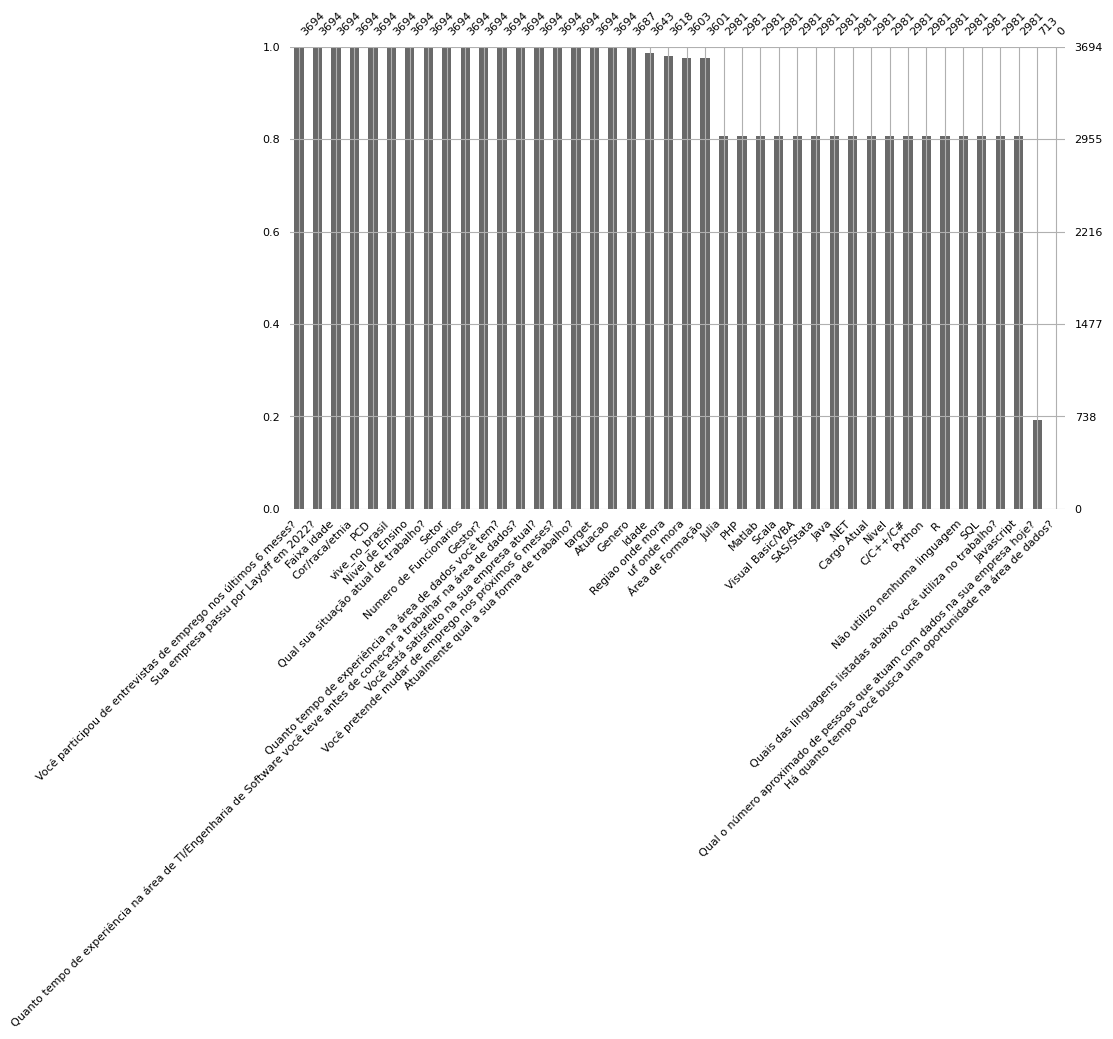

In [12]:
# Visualização dos NA
msno.bar(df_filtered, sort="descending", figsize=(10,6), fontsize=8).grid()

In [13]:
# Visualização onde temos Nível = NA
df_filtered[(df_filtered['Nivel'].isna())].iloc[:,5:20].sample(10)

,PCD,vive_no_brasil,uf onde mora,Regiao onde mora,Nivel de Ensino,Área de Formação,Qual sua situação atual de trabalho?,Setor,Numero de Funcionarios,Gestor?,Cargo Atual,Nivel,Quanto tempo de experiência na área de dados você tem?,Quanto tempo de experiência na área de TI/Engenharia de Software você teve antes de começar a trabalhar na área de dados?,Você está satisfeito na sua empresa atual?
2460,Não,True,RJ,Sudeste,Pós-graduação,Economia/ Administração / Contabilidade / Fina...,Empregado (CLT),Internet/Ecommerce,de 1.001 a 3.000,True,NaN,NaN,de 7 a 10 anos,Menos de 1 ano,True
2114,Não,True,SC,Sul,Pós-graduação,Outra opção,Empregado (CLT),Indústria,Acima de 3.000,True,NaN,NaN,de 7 a 10 anos,de 1 a 2 anos,False
4132,Não,True,ES,Sudeste,Graduação/Bacharelado,Outra opção,Empreendedor ou Empregado (CNPJ),Marketing,de 51 a 100,True,NaN,NaN,de 3 a 4 anos,Não tive experiência na área de TI/Engenharia ...,True
3510,Não,True,DF,Centro-oeste,Pós-graduação,Economia/ Administração / Contabilidade / Fina...,Prefiro não informar,Setor Imobiliário/ Construção Civil,de 1 a 5,True,NaN,NaN,Mais de 10 anos,de 7 a 10 anos,True
446,Não,True,BA,Nordeste,Pós-graduação,Marketing / Publicidade / Comunicação / Jornal...,Empreendedor ou Empregado (CNPJ),Outra Opção,Acima de 3.000,True,NaN,NaN,Não tenho experiência na área de dados,Não tive experiência na área de TI/Engenharia ...,True
376,Não,True,PR,Sul,Pós-graduação,Computação / Engenharia de Software / Sistemas...,Empregado (CLT),Área da Saúde,de 501 a 1.000,True,NaN,NaN,Mais de 10 anos,Mais de 10 anos,True
3714,Não,True,RJ,Sudeste,Pós-graduação,Computação / Engenharia de Software / Sistemas...,Empreendedor ou Empregado (CNPJ),Varejo,de 101 a 500,True,NaN,NaN,Mais de 10 anos,Mais de 10 anos,True
1401,Não,True,SP,Sudeste,Graduação/Bacharelado,Outras Engenharias,Empreendedor ou Empregado (CNPJ),Finanças ou Bancos,de 1 a 5,True,NaN,NaN,de 4 a 6 anos,Não tive experiência na área de TI/Engenharia ...,False
3520,Não,True,SP,Sudeste,Não tenho graduação formal,NaN,Empregado (CLT),Finanças ou Bancos,de 501 a 1.000,True,NaN,NaN,de 7 a 10 anos,Mais de 10 anos,True
2359,Não,True,MG,Sudeste,Pós-graduação,Computação / Engenharia de Software / Sistemas...,Servidor Público,Setor Público,Acima de 3.000,True,NaN,NaN,de 3 a 4 anos,Não tive experiência na área de TI/Engenharia ...,True


In [14]:
# é possível verificar que todos os valores onde temos 'Cargo Atual' e 'Nivel' como NA, são cargos de Gestor, ou seja, não precisamos da coluna Gestor. Podemos imputar 'Gestor' na coluna 'Cargo Atual' e 'Nivel' para todos os NA e remover a coluna 'Gestor?'
df_filtered[(df_filtered['Cargo Atual'].isna())]['Gestor?'].value_counts()

True    713
Name: Gestor?, dtype: int64

In [15]:
# Valores da coluna gestor pra onde temos Nivel NA
df_filtered[(df_filtered['Nivel'].isna())]['Gestor?'].value_counts()

True    713
Name: Gestor?, dtype: int64

In [16]:
# Valores da coluna gestor pra onde temos Cargo Atual NOT NA
df_filtered[(df_filtered['Cargo Atual'].isna() == False)]['Gestor?'].value_counts()

False    2981
Name: Gestor?, dtype: int64

In [17]:
# Valores da coluna gestor pra onde temos Nivel NOT NA
df_filtered[(df_filtered['Nivel'].isna() == False)]['Gestor?'].value_counts()

False    2981
Name: Gestor?, dtype: int64

In [18]:
# Valores da coluna Cargo ATual
df_filtered[(df_filtered['Cargo Atual'].isna() == False)]['Cargo Atual'].value_counts()

Analista de Dados/Data Analyst                                         639
Cientista de Dados/Data Scientist                                      556
Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect    490
Analista de BI/BI Analyst                                              378
Outra Opção                                                            281
Analista de Negócios/Business Analyst                                  123
Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas            106
Analista de Suporte/Analista Técnico                                    72
Analytics Engineer                                                      70
Engenheiro de Machine Learning/ML Engineer                              69
Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)                      51
Analista de Inteligência de Mercado/Market Intelligence                 29
Outras Engenharias (não inclui dev)                                     28
Professor                

In [19]:
# Removendo coluna 'Gestor?' e preenchendo os NA com "Gestor" nas colunas 'Nivel' e 'Cargo Atual'
df_filtered2 = df_filtered.copy()
df_filtered2 = df_filtered2.drop(columns=['Gestor?'])
df_filtered2[['Nivel','Cargo Atual']] = df_filtered[['Nivel','Cargo Atual']].fillna('Gestor')
df_filtered2.isna().sum()

target                                                                                                                          0
Idade                                                                                                                          51
Faixa idade                                                                                                                     0
Genero                                                                                                                          7
Cor/raca/etnia                                                                                                                  0
PCD                                                                                                                             0
vive_no_brasil                                                                                                                  0
uf onde mora                                                                              

Vou remover as colunas 'Idade', pois esta apresenta valores NA além de também ja termos a coluna de faixa etária.  
Também irei remover as colunas que possuem MUITOS valores NA como 'Há quanto tempo você busca uma oportunidade na área de dados?' e 'Qual o número aproximado de pessoas que atuam com dados na sua empresa hoje?'.  
Ainda a decidir se irei remover as colunas das linguagens utilizadas no trabalho

In [20]:
df_filtered2 = df_filtered2.drop(columns=["Qual o número aproximado de pessoas que atuam com dados na sua empresa hoje?","Há quanto tempo você busca uma oportunidade na área de dados?", "Idade"])
df_filtered2.isna().sum()

target                                                                                                                         0
Faixa idade                                                                                                                    0
Genero                                                                                                                         7
Cor/raca/etnia                                                                                                                 0
PCD                                                                                                                            0
vive_no_brasil                                                                                                                 0
uf onde mora                                                                                                                  91
Regiao onde mora                                                                                 

In [21]:
# Checando a relação das colunas 'vive_no_brasil' com 'uf onde mora' e 'Regiao onde mora'
# valores de 'vive_no_brasil' quando temos Regiao onde mora NA
df_filtered2[(df_filtered2['Regiao onde mora'].isna())]['vive_no_brasil'].value_counts()

False    76
Name: vive_no_brasil, dtype: int64

In [22]:
# valores de 'vive_no_brasil' quando temos Regiao onde mora not NA
df_filtered2[(df_filtered2['Regiao onde mora'].isna() == False)]['vive_no_brasil'].value_counts()

True    3618
Name: vive_no_brasil, dtype: int64

Novamente, aqui irei remover a coluna vive_no_brasil e preencher os valores de NA da coluna 'Regiao onde mora' com 'Exterior'. Também irei remover a coluna 'uf onde mora' e manter apenas a 'Regiao onde mora'

In [23]:
df_filtered2 = df_filtered2.drop(columns=['vive_no_brasil', 'uf onde mora'])
df_filtered2['Regiao onde mora'] = df_filtered2['Regiao onde mora'].fillna('Exterior')
df_filtered2.isna().sum()

target                                                                                                                         0
Faixa idade                                                                                                                    0
Genero                                                                                                                         7
Cor/raca/etnia                                                                                                                 0
PCD                                                                                                                            0
Regiao onde mora                                                                                                               0
Nivel de Ensino                                                                                                                0
Área de Formação                                                                                 

In [24]:
# Visualizando onde temos valores de Genero NA.
# Tenhos três opções: preencher com 'Prefiro não informar', preencher aleatóriamente com base nos valores que temos ou remover esses registros. 
# Vou decidir por dropar os NA da coluna Genero"Prefiro não informar" 
# Vale repensar/testar se vale a pena remover esses juntos com os "Prefiro não informar"
df_filtered2[(df_filtered2['Genero'].isna())]

,target,Faixa idade,Genero,Cor/raca/etnia,PCD,Regiao onde mora,Nivel de Ensino,Área de Formação,Qual sua situação atual de trabalho?,Setor,...,.NET,Java,Julia,SAS/Stata,Visual Basic/VBA,Scala,Matlab,PHP,Javascript,Não utilizo nenhuma linguagem
232,de R$ 2.001/mês a R$ 3.000/mês,25-29,NaN,Branca,Não,Sul,Pós-graduação,Ciências Sociais,Empregado (CLT),Área de Consultoria,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1484,de R$ 1.001/mês a R$ 2.000/mês,25-29,NaN,Preta,Não,Sudeste,Graduação/Bacharelado,Outras Engenharias,Estagiário,Finanças ou Bancos,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2463,de R$ 2.001/mês a R$ 3.000/mês,25-29,NaN,Preta,Não,Centro-oeste,Graduação/Bacharelado,Ciências Sociais,Empreendedor ou Empregado (CNPJ),Filantropia/ONG's,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2583,de R$ 8.001/mês a R$ 12.000/mês,25-29,NaN,Branca,Não,Sudeste,Pós-graduação,Economia/ Administração / Contabilidade / Fina...,Empregado (CLT),Setor Imobiliário/ Construção Civil,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3302,de R$ 3.001/mês a R$ 4.000/mês,25-29,NaN,Parda,Não,Sul,Pós-graduação,Outra opção,Servidor Público,Setor Público,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3722,de R$ 2.001/mês a R$ 3.000/mês,22-24,NaN,Branca,Não,Sudeste,Graduação/Bacharelado,Computação / Engenharia de Software / Sistemas...,Estagiário,Tecnologia/Fábrica de Software,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3955,de R$ 16.001/mês a R$ 20.000/mês,22-24,NaN,Branca,Não,Sudeste,Mestrado,Outras Engenharias,Empregado (CLT),Área de Consultoria,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df_filtered2['Genero'].value_counts()

Masculino               2790
Feminino                 886
Prefiro não informar      11
Name: Genero, dtype: int64

In [26]:
df_filtered3 = df_filtered2.copy()
df_filtered3 = df_filtered3.dropna(subset=['Genero'])
df_filtered3.isna().sum()

target                                                                                                                         0
Faixa idade                                                                                                                    0
Genero                                                                                                                         0
Cor/raca/etnia                                                                                                                 0
PCD                                                                                                                            0
Regiao onde mora                                                                                                               0
Nivel de Ensino                                                                                                                0
Área de Formação                                                                                 

In [27]:
# Checando valores da coluna 'Área de Formação'
df_filtered3[(df_filtered3['Área de Formação'].isna())]

,target,Faixa idade,Genero,Cor/raca/etnia,PCD,Regiao onde mora,Nivel de Ensino,Área de Formação,Qual sua situação atual de trabalho?,Setor,...,.NET,Java,Julia,SAS/Stata,Visual Basic/VBA,Scala,Matlab,PHP,Javascript,Não utilizo nenhuma linguagem
44,Menos de R$ 1.000/mês,17-21,Masculino,Parda,Não,Sul,Não tenho graduação formal,NaN,Prefiro não informar,Outra Opção,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
171,de R$ 16.001/mês a R$ 20.000/mês,40-44,Masculino,Branca,Não,Sudeste,Não tenho graduação formal,NaN,Empregado (CLT),Tecnologia/Fábrica de Software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,de R$ 1.001/mês a R$ 2.000/mês,40-44,Feminino,Preta,Não,Sudeste,Não tenho graduação formal,NaN,Empregado (CLT),Varejo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
307,de R$ 3.001/mês a R$ 4.000/mês,30-34,Masculino,Parda,Não,Sul,Não tenho graduação formal,NaN,Empregado (CLT),Setor Alimentício,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
318,de R$ 4.001/mês a R$ 6.000/mês,25-29,Masculino,Branca,Não,Sul,Não tenho graduação formal,NaN,Empregado (CLT),Educação,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4163,de R$ 6.001/mês a R$ 8.000/mês,25-29,Masculino,Branca,Não,Sudeste,Não tenho graduação formal,NaN,Empregado (CLT),Área de Consultoria,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4179,de R$ 3.001/mês a R$ 4.000/mês,30-34,Masculino,Parda,Não,Sudeste,Prefiro não informar,NaN,Empregado (CLT),Outra Opção,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4208,de R$ 3.001/mês a R$ 4.000/mês,30-34,Masculino,Branca,Não,Sudeste,Não tenho graduação formal,NaN,Empregado (CLT),Outra Opção,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4238,de R$ 2.001/mês a R$ 3.000/mês,22-24,Masculino,Branca,Não,Nordeste,Não tenho graduação formal,NaN,Empregado (CLT),Setor Alimentício,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
# Confirmando que todos os valores de Área de formação NA são pessoal que nao tem graduação formal
df_filtered3[(df_filtered3['Área de Formação'].isna())]['Nivel de Ensino'].value_counts()

Não tenho graduação formal    84
Prefiro não informar           9
Name: Nivel de Ensino, dtype: int64

In [29]:
# Atribuindo 'Sem Formação Formal' para os valores NA que têm 'Nivel de Ensino' com valor = 'Não tenho graduação formal'.  Irei remover os NA restante logo em seguida

#df_filtered3[((df_filtered3['Área de Formação'].isna()) & (df_filtered3['Nivel de Ensino'] == 'Não tenho graduação formal'))]['Área de Formação'] = 'Sem Formação Formal' --> errado

df_filtered3.loc[(df_filtered3['Área de Formação'].isna()) & (df_filtered3['Nivel de Ensino'] == 'Não tenho graduação formal'), 'Área de Formação'] = 'Sem Formação Formal'
df_filtered3 = df_filtered3.dropna(subset=['Área de Formação'])


In [30]:
df_filtered3.isna().sum()

target                                                                                                                         0
Faixa idade                                                                                                                    0
Genero                                                                                                                         0
Cor/raca/etnia                                                                                                                 0
PCD                                                                                                                            0
Regiao onde mora                                                                                                               0
Nivel de Ensino                                                                                                                0
Área de Formação                                                                                 

Agora vou remover a pergunta das linguagens utilizadas devido ao grande numero de NA

In [31]:
df_filtered3 = df_filtered3.iloc[:, :-15]
df_filtered3.isna().sum()

target                                                                                                                       0
Faixa idade                                                                                                                  0
Genero                                                                                                                       0
Cor/raca/etnia                                                                                                               0
PCD                                                                                                                          0
Regiao onde mora                                                                                                             0
Nivel de Ensino                                                                                                              0
Área de Formação                                                                                               

In [32]:
df_filtered3.shape

(3678, 21)

In [33]:
# Checando valores da coluna 'Qual sua situação atual de trabalho?'
df_filtered3['Área de Formação'].value_counts()

Computação / Engenharia de Software / Sistemas de Informação/ TI          1367
Outras Engenharias                                                         827
Economia/ Administração / Contabilidade / Finanças/ Negócios               558
Estatística/ Matemática / Matemática Computacional/ Ciências Atuariais     355
Outra opção                                                                161
Marketing / Publicidade / Comunicação / Jornalismo                         108
Química / Física                                                            85
Sem Formação Formal                                                         84
Ciências Biológicas/ Farmácia/ Medicina/ Área da Saúde                      80
Ciências Sociais                                                            53
Name: Área de Formação, dtype: int64

In [34]:
# Visualizando os valores de todas as variáveis
colunas = df_filtered3.columns
for i in colunas:
    print(i)
    print(df_filtered3[f'{i}'].value_counts())

target
de R$ 8.001/mês a R$ 12.000/mês     751
de R$ 4.001/mês a R$ 6.000/mês      582
de R$ 6.001/mês a R$ 8.000/mês      527
de R$ 12.001/mês a R$ 16.000/mês    437
de R$ 3.001/mês a R$ 4.000/mês      300
de R$ 2.001/mês a R$ 3.000/mês      280
de R$ 16.001/mês a R$ 20.000/mês    228
de R$ 1.001/mês a R$ 2.000/mês      213
de R$ 20.001/mês a R$ 25.000/mês    134
de R$ 25.001/mês a R$ 30.000/mês     77
de R$ 30.001/mês a R$ 40.000/mês     70
Acima de R$ 40.001/mês               45
Menos de R$ 1.000/mês                34
Name: target, dtype: int64
Faixa idade
25-29    1225
30-34     966
35-39     521
22-24     379
40-44     237
45-49     126
17-21     106
50-54      71
55+        47
Name: Faixa idade, dtype: int64
Genero
Masculino               2785
Feminino                 883
Prefiro não informar      10
Name: Genero, dtype: int64
Cor/raca/etnia
Branca                  2388
Parda                    893
Preta                    239
Amarela                  111
Prefiro não informar    

É possível verificar que temos pouquissimos valores nas faixas de menos de R$1.000 e mais de R$25.000.  
Portanto optarei por diluir essas faixas de salários nas faixas mais próximas à eles (Menos de R$1000 passará a ser representada juntamente com a de R$1000 a R$2000 e as faixas acima de R$20.000 irá compor uma nica faixa)

In [35]:
df_filtered3['target'].value_counts()

de R$ 8.001/mês a R$ 12.000/mês     751
de R$ 4.001/mês a R$ 6.000/mês      582
de R$ 6.001/mês a R$ 8.000/mês      527
de R$ 12.001/mês a R$ 16.000/mês    437
de R$ 3.001/mês a R$ 4.000/mês      300
de R$ 2.001/mês a R$ 3.000/mês      280
de R$ 16.001/mês a R$ 20.000/mês    228
de R$ 1.001/mês a R$ 2.000/mês      213
de R$ 20.001/mês a R$ 25.000/mês    134
de R$ 25.001/mês a R$ 30.000/mês     77
de R$ 30.001/mês a R$ 40.000/mês     70
Acima de R$ 40.001/mês               45
Menos de R$ 1.000/mês                34
Name: target, dtype: int64

In [36]:
df_filtered3['target'] = np.where((df_filtered3['target'] == 'Menos de R$ 1.000/mês'), 'de R$ 1.001/mês a R$ 2.000/mês',
                         np.where((df_filtered3['target'] == 'Acima de R$ 40.001/mês') | (df_filtered3['target'] == 'de R$ 30.001/mês a R$ 40.000/mês') | (df_filtered3['target'] == 'de R$ 25.001/mês a R$ 30.000/mês'),'de R$ 20.001/mês a R$ 25.000/mês',
                                  df_filtered3['target']))

In [37]:
df_filtered3['target'] = df_filtered3['target'].replace(to_replace=['de R$ 1.001/mês a R$ 2.000/mês', 'de R$ 20.001/mês a R$ 25.000/mês'], value = ['Até R$ 2.000/mês', 'Acima de R$20.001/mês'])

In [38]:
df_filtered3['target'].value_counts()

de R$ 8.001/mês a R$ 12.000/mês     751
de R$ 4.001/mês a R$ 6.000/mês      582
de R$ 6.001/mês a R$ 8.000/mês      527
de R$ 12.001/mês a R$ 16.000/mês    437
Acima de R$20.001/mês               326
de R$ 3.001/mês a R$ 4.000/mês      300
de R$ 2.001/mês a R$ 3.000/mês      280
Até R$ 2.000/mês                    247
de R$ 16.001/mês a R$ 20.000/mês    228
Name: target, dtype: int64

In [39]:
# Vou Fazer a mesma coisa com a variávei numero de funcionarios
df_filtered3['Numero de Funcionarios'].value_counts()

Acima de 3.000      1520
de 101 a 500         701
de 1.001 a 3.000     450
de 501 a 1.000       342
de 11 a 50           249
de 51 a 100          240
de 1 a 5             113
de 6 a 10             63
Name: Numero de Funcionarios, dtype: int64

In [40]:
# df_filtered3['Numero de Funcionarios'] = np.where((df_filtered3['Numero de Funcionarios'] == 'de 1 a 5') | (df_filtered3['Numero de Funcionarios'] == 'de 6 a 10'), 'de 11 a 50',
#                                                   df_filtered3['Numero de Funcionarios'])

In [41]:
df_filtered3['Numero de Funcionarios'] = df_filtered3['Numero de Funcionarios'].replace(to_replace=['de 1 a 5', 'de 6 a 10', 'de 11 a 50'], value = ['de 1 a 50', 'de 1 a 50','de 1 a 50'])

In [42]:
df_filtered3['Numero de Funcionarios'].value_counts()

Acima de 3.000      1520
de 101 a 500         701
de 1.001 a 3.000     450
de 1 a 50            425
de 501 a 1.000       342
de 51 a 100          240
Name: Numero de Funcionarios, dtype: int64

# Análise Exploratória

In [171]:
# Renomeando novamente o dataframe para ficar mais fácil a escrita do código
df = df_filtered3.copy()

In [78]:
# Transformando a coluna target em uma categoria ordenada
order = [ # ordem dos valores do eixo x
    "Até R$ 2.000/mês",
    "de R$ 2.001/mês a R$ 3.000/mês",
    "de R$ 3.001/mês a R$ 4.000/mês",
    "de R$ 4.001/mês a R$ 6.000/mês",
    "de R$ 6.001/mês a R$ 8.000/mês",
    "de R$ 8.001/mês a R$ 12.000/mês",
    "de R$ 12.001/mês a R$ 16.000/mês",
    "de R$ 16.001/mês a R$ 20.000/mês",
    "Acima de R$20.001/mês"
] 
df["target"] = pd.Categorical(df["target"], categories=order, ordered=True)

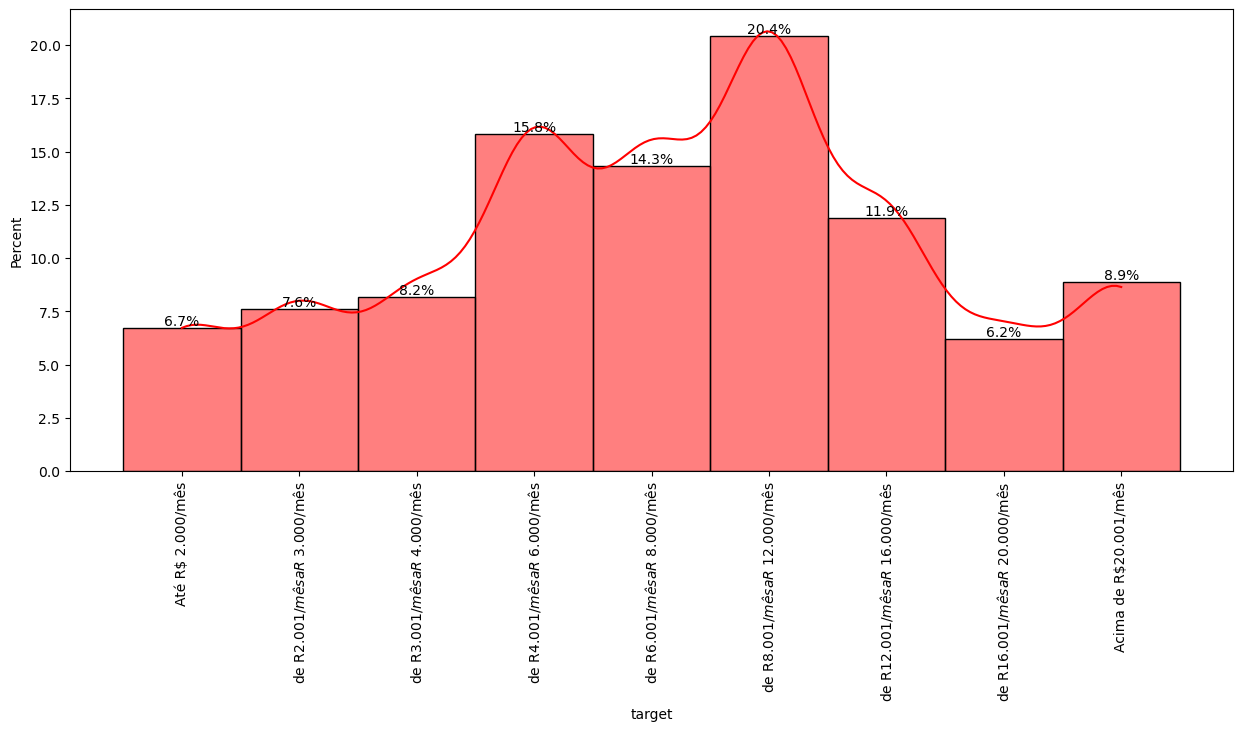

In [94]:
# Plot do hist de distribuição de salários de profissionais de Área de Dados
plt.figure(figsize=(15, 6))
ax = sns.histplot(data=df, x="target", bins=20, color='r', kde=True, stat='percent')

# Adicionar as porcentagens acima das barras
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{(height):.1f}%'
    ax.annotate(percentage, 
                xy=(p.get_x() + p.get_width() / 2., height),
                xytext=(0, 5),  # 5 points vertical offset
                textcoords="offset points",
                ha='center', va='center')

plt.xticks(rotation=90)
plt.show()

>> É possível ver que, de acordo com nosso dataset, o salário da maioria dos profissionais está entre 4k e 12k. (cerca de 50% dos salários)  
A faixa de 8k a 12k é a que contempla o maior número de pessoas, com aprox. 20% dos salários

In [172]:
# Checando se pessoas que tem como sua forma de emprego presencial tende a querer mudar mais de emprego nos próximos 6 meses ou satisfação do funcionário.
# Irei alterar o valor de Modelo hibrido Flexivel para apenas "Modelo híbrido flexível" para melhor visualização do gráfico
df['Atualmente qual a sua forma de trabalho?'] = df['Atualmente qual a sua forma de trabalho?'].replace(
    'Modelo híbrido flexível (o funcionário tem liberdade para escolher quando estar no escritório presencialmente)',
    'Modelo híbrido flexível'
)


# Também irei alterar a ordem dos valores que estarei dispondo no eixo x ("Atualmente qual a sua forma de trabalho?") e da variável 'Você pretende mudar de emprego nos próximos 6 meses?'
order = ["Modelo 100% remoto",
         'Modelo híbrido flexível',
         'Modelo híbrido com dias fixos de trabalho presencial',
         'Modelo 100% presencial']

order2 = ["Estou em busca de oportunidades dentro ou fora do Brasil",
          "Estou em busca de oportunidades, mas apenas fora do Brasil",
          "Não estou buscando, mas me considero aberto a outras oportunidades",
          "Não estou buscando e não pretendo mudar de emprego nos próximos 6 meses"
          ]


# Reordenar as categorias na coluna 'Atualmente qual a sua forma de trabalho?'
df['Atualmente qual a sua forma de trabalho?'] = pd.Categorical(df['Atualmente qual a sua forma de trabalho?'], categories=order, ordered=True)
df['Você pretende mudar de emprego nos próximos 6 meses?'] = pd.Categorical(df['Você pretende mudar de emprego nos próximos 6 meses?'], categories=order2, ordered=True)


In [183]:
## Acredito que o gráfico stacked fica melhor para a visualização deste tipo de variáveis

# plt.figure(figsize=(12, 8))
# ax = sns.countplot(data=df, hue='Você pretende mudar de emprego nos próximos 6 meses?', x='Atualmente qual a sua forma de trabalho?')

# # Adicionar os números acima das barras
# for container in ax.containers:
#     ax.bar_label(container, label_type='edge', padding=3)

# plt.title('Distribuição das respostas sobre mudança de emprego por forma de trabalho')
# plt.xlabel('Você pretende mudar de emprego nos próximos 6 meses?')
# plt.ylabel('Contagem')
# plt.xticks(rotation=90)
# plt.legend(title='Atualmente qual a sua forma de trabalho?')
# plt.show()

Acredito que a versão stacked fique melhor para visualização. Testar ela

In [182]:
## Não está proporcional e sim em números absolutos, o que dificulta a comparação das categorias
# contingency_table = pd.crosstab(df['Atualmente qual a sua forma de trabalho?'],
#                                 df['Você pretende mudar de emprego nos próximos 6 meses?']
#                                 )

# # Criar um gráfico de barras empilhadas
# contingency_table.plot(kind='bar', stacked=True, figsize=(10, 7))
# plt.title('Distribuição das respostas sobre mudança de emprego por forma de trabalho')
# plt.xlabel('Você pretende mudar de emprego nos próximos 6 meses?')
# plt.ylabel('Contagem')
# plt.legend(title='Atualmente qual a sua forma de trabalho?')
# plt.xticks(rotation=45)
# plt.show()

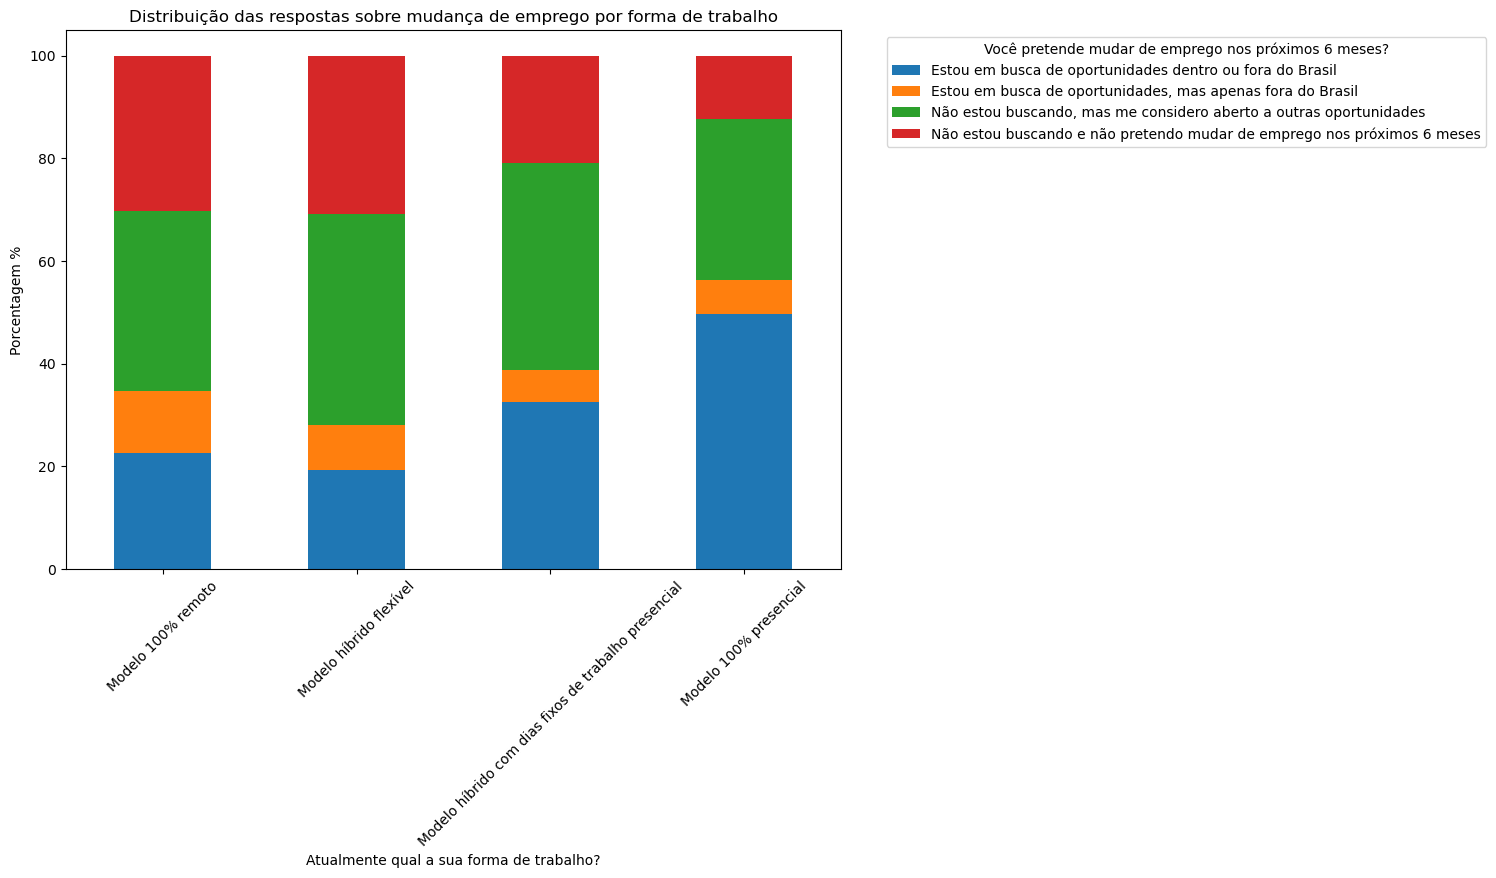

In [181]:
contingency_table = pd.crosstab(df['Atualmente qual a sua forma de trabalho?'],
                                df['Você pretende mudar de emprego nos próximos 6 meses?'])

# Calcular as porcentagens por linha
contingency_table_percent = contingency_table.apply(lambda x: x / x.sum(), axis=1) * 100

# Criar um gráfico de barras empilhadas com porcentagens
contingency_table_percent.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Distribuição das respostas sobre mudança de emprego por forma de trabalho')
plt.xlabel('Atualmente qual a sua forma de trabalho?')
plt.ylabel('Porcentagem %')
plt.legend(title='Você pretende mudar de emprego nos próximos 6 meses?', loc = 'upper left', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.show()

>> É possível inferir que pessoas com traballho 100% remoto ou híbrido flexível tendem a não estar procurando por um novo emprego nos próximos 6 meses.

# Pré-Processamento dos Dados - pt2

Como todas as variáveis que estão sendo usadas são categóricas, teremos que aplicar as técnicas de Label Encoding e One Hot Encoding

In [ ]:
df_filtered3['Atuacao'].value_counts()

In [ ]:
# Separando colunas
cols_encod = ['target', 'Faixa idade','Nivel de Ensino','Nivel','Quanto tempo de experiência na área de dados você tem?',
              'Quanto tempo de experiência na área de TI/Engenharia de Software você teve antes de começar a trabalhar na área de dados?']
cols_one_hot = ['Genero','Cor/raca/etnia', 'PCD','Regiao onde mora','Área de Formação','Qual sua situação atual de trabalho?','Numero de Funcionarios', 'Setor',
                'Cargo Atual','Você participou de entrevistas de emprego nos últimos 6 meses?','Você pretende mudar de emprego nos próximos 6 meses?',
                'Atualmente qual a sua forma de trabalho?','Sua empresa passu por Layoff em 2022?','Atuacao']
col_binarias = ['Você está satisfeito na sua empresa atual?']

In [ ]:
# Encoding

faixa_salario_map = {
    'Até R$ 2.000/mês':0,
    'de R$ 2.001/mês a R$ 3.000/mês':1,
    'de R$ 3.001/mês a R$ 4.000/mês':2,
    'de R$ 4.001/mês a R$ 6.000/mês':3,
    'de R$ 6.001/mês a R$ 8.000/mês':4,
    'de R$ 8.001/mês a R$ 12.000/mês':5,
    'de R$ 12.001/mês a R$ 16.000/mês':6,
    'de R$ 16.001/mês a R$ 20.000/mês':7,
    'Acima de R$20.001/mês':8
                     }

faixa_etaria_map ={
    '17-21':0,
    '22-24':1,
    '25-29':2,
    '30-34':3,
    '35-39':4,    
    '40-44':5,
    '45-49':6,    
    '50-54':7,
    '55+':8 
}

nivel_ensino_map = {
    'Não tenho graduação formal':0,
    'Estudante de Graduação':1,
    'Graduação/Bacharelado':2,
    'Pós-graduação':3,    
    'Mestrado':4,
    'Doutorado ou Phd':5,    
}

nivel_map = {
    "Júnior":0,
    "Pleno":1,
    "Sênior":2,
    "Gestor":3    
}

# Acredito que vou aplica one-hot encoding enssa variavel
# num_funcionario_map = { 
#     'de 1 a 50':0,
#     'de 51 a 100':1,
#     'de 101 a 500':2,
#     'de 501 a 1.000':3,
#     'de 1.001 a 3.000':4,
#     'Acima de 3.000':5
# }

tempo_exp_map = {
    'Não tenho experiência na área de dados':0,
    'Menos de 1 ano':1,
    'de 1 a 2 anos':2,
    'de 3 a 4 anos':3,
    'de 4 a 6 anos':4,
    'de 7 a 10 anos':5,
    'Mais de 10 anos':6
}

tempo_exp_ti_map = {
    'Não tive experiência na área de TI/Engenharia de Software antes de começar a trabalhar na área de dados':0,
    'Menos de 1 ano':1,
    'de 1 a 2 anos':2,
    'de 3 a 4 anos':3,
    'de 5 a 6 anos':4,
    'de 7 a 10 anos':5,
    'Mais de 10 anos':6
}

# Lista com dicionários para aplicar no meu df
#dictss = [faixa_salario_map,faixa_etaria_map,nivel_ensino_map,nivel_map,num_funcionario_map,tempo_exp_map,tempo_exp_ti_map]
dictss = [faixa_salario_map,faixa_etaria_map,nivel_ensino_map,nivel_map,tempo_exp_map,tempo_exp_ti_map]

> df_encoded vai conter os pre processamento de label encoding e one_hot encoding

In [ ]:
df_encoded = df_filtered3.copy()

In [ ]:
# Aplicando o Label Enconding
for i in range(0,len(cols_encod)):
    df_encoded[cols_encod[i]] = df_encoded[cols_encod[i]].map(dictss[i])

In [ ]:
# Aplicando o One hot Encoding
def one_hot_encoding(df, cols):
    """
    Realiza one-hot encoding.
    
    Parâmetros:
        df (DataFrame): DataFrame contendo as variáveis categóricas.
        cols (list): Lista das colunas a serem codificadas em one-hot encoding.
        
    Retorna:
        DataFrame: O DataFrame com as colunas especificadas codificadas em one-hot encoding.
    """
    return pd.get_dummies(df, columns=cols)



In [ ]:
df_encoded = one_hot_encoding(df = df_encoded, cols = cols_one_hot)
df_encoded.head()

In [ ]:
# Aplicando 0 e 1 pra vairáveis booleana 'Você está satisfeito na sua empresa atual?'
df_encoded['Você está satisfeito na sua empresa atual?'] = df_encoded['Você está satisfeito na sua empresa atual?'].map({True: 1, False: 0})
df_encoded.head()

## Separando em Dados de Treino e Teste

In [ ]:
# Copia do df pre processado
df_ml = df_encoded.copy()

X = df_ml.drop('target',axis=1)
y = df_ml['target']

In [ ]:
# Aplicando StandardScaler() e MinMaxScaler() (padronizacao e normalização)

def normalizacao(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)

def padronizacao(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)
    

In [ ]:
# Fuunção para separar a coluna target das preditoras e separar em amostra de treino e teste
def split_data(df, target_column, test_size=0.25, random_state=19):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
    return X_train, X_test, y_train, y_test   


In [ ]:
# Atribuindo os dados de treino e teste
X_train, X_test, y_train, y_test = split_data(df= df_ml, target_column='target', test_size=0.25, random_state=19)

In [ ]:
# Conjunto de treino normalizado
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [ ]:
X_train_scaler

# Feature Selection

## Chi2

In [ ]:
# Verificando a correlação chi2 de person das variáveis

# funcao feature selection com chi2
def select_features_chi2(X_train, y_train, X_test, k='all'):
    
    fs = SelectKBest(score_func=chi2, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [ ]:
X_train_fs, X_test_fs, fs = select_features_chi2(X_train, y_train, X_test, k=50)

In [ ]:
# Melhores Features de acordo com chi2
indices = np.argsort(fs.scores_)[::-1]
for i in indices:
    if fs.scores_[i]>50:
        print(f'Feature {df_ml.columns[i]}: {fs.scores_[i]}')

In [ ]:
# visualização
for i in range(0,len(fs.scores_)):
    print(f'{i}: {fs.scores_[indices[i]]}')

In [ ]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

## Mutual Information Feature Selection

In [ ]:
# feature selection
def select_features_mis(X_train, y_train, X_test, k='all'):
    fs = SelectKBest(score_func=mutual_info_classif, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [ ]:
X_train_fs2, X_test_fs2, fs2 = select_features_mis(X_train, y_train, X_test, k=50)

In [ ]:
# Melhores Features de acordo com mutual information
indices = np.argsort(fs2.scores_)[::-1]
for i in indices:
    if fs2.scores_[i]> 0.01:
        print(f'Feature {df_ml.columns[i]}: {fs2.scores_[i]}')

In [ ]:
plt.bar([i for i in range(len(fs2.scores_))], fs2.scores_)
plt.show()

Lembrar de colocar o a parte de separar o dataset em treino e teste antes dessas linhas

Testar no modelo de regressao logitsica pode ser uma boa poi ele se beneficia de tirar variáveiss nao significativas

# Machine Learning

- Random Forest (RF)
- Modelo de Regressão Logistico Multinomial
- Gradient Boosting Machines (GBM)
- Redes Neurais Artificiais (NN)
- Support Vector Machines (SVM)

### Funções

In [ ]:
# Função para rodar modelo de Random Forest tunando os hiper parametros com o GridSearch

def ML_RandomForest(X_train, y_train, X_test, y_test, random_state=19, scoring_method='f1_weighted', n_jobs=-1,
                    n_estimators=[100,200,300], max_depth =[None, 10, 20], min_samples_split = [2,5,10], min_samples_leaf = [1,2,4]):
    
    """Função para rodar nossos dados de treino e teste em um modelo de Random Forest"""
    
    # Buscando os melhores hiperparametros com o GridSearch
    param_grid = {
        'n_estimators': n_estimators,  # Número de árvores na floresta
        'max_depth': max_depth,        # Profundidade máxima de cada árvore
        'min_samples_split': min_samples_split,    # O número mínimo de amostras necessárias para dividir um nó interno
        'min_samples_leaf': min_samples_leaf      # O número mínimo de amostras necessárias para estar em um nó folha
    }

    # Inicialize o modelo Random Forest
    random_forest = RandomForestClassifier(random_state=random_state)

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring = scoring_method, n_jobs=n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado
    y_pred = grid_search.predict(X_test) 

    # Avalie o desempenho do modelo otimizado
    accuracy_rf_optimized = accuracy_score(y_test, y_pred)
    f1_rf_optimized = f1_score(y_test, y_pred, average='weighted')
    precision_rf_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_rf_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_rf_optimized = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy_rf_optimized)
    print("F1-Score:", f1_rf_optimized)
    print("Precisão:", precision_rf_optimized)
    print("Revocação:", recall_rf_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_rf_optimized)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    return grid_search       

In [ ]:
# Função para rodar modelo Logistico Mltinomial tunando os hiper parametros com o GridSearch

def ML_LogMult(X_train, y_train, X_test, y_test, random_state=19, scoring_method='f1_weighted', n_jobs=-1):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10],  # Parâmetro de regularização
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],  # Algoritmo de otimização
        'max_iter': [100, 200, 300]  # Número máximo de iterações
    }

    # Inicialize o modelo de regressão logística multinomial
    logistic_model = LogisticRegression(multi_class='multinomial', random_state=random_state)

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring=scoring_method, n_jobs=n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado usando o conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Avalie o desempenho do modelo otimizado
    accuracy_lm_optimized = accuracy_score(y_test, y_pred)
    f1_lm_optimized = f1_score(y_test, y_pred, average='weighted')
    precision_lm_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_lm_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_lm_optimized = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy_lm_optimized)
    print("F1-Score:", f1_lm_optimized)
    print("Precisão:", precision_lm_optimized)
    print("Revocação:", recall_lm_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_lm_optimized)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    return grid_search       

In [ ]:
# Função para rodar modelo Logistico XGBoost tunando os hiper parametros com o GridSearch

def ML_Xgboost(X_train, y_train, X_test, y_test, scoring_method='f1_weighted',n_jobs=-1 ):
    
    
    num_class = len(y_train.value_counts())
    model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_class)

    # Defina os hiperparâmetros que deseja ajustar
    param_grid = {
        'n_estimators': [100, 200, 300],  
        'max_depth': [3, 4, 5],        
        'learning_rate': [0.01, 0.1, 0.2]  
    }

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring_method, n_jobs = n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado usando o conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    accuracy_xgb_optimized = accuracy_score(y_test, y_pred)
    f1_xgb_optimized = f1_score(y_test, y_pred,average='weighted')
    precision_xgb_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_xgb_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_xgb_optimized = confusion_matrix(y_test, y_pred)
    print(f'Acuracia XGBoost: {accuracy_xgb_optimized}')
    print(f'F1-score LXGBoost: {f1_xgb_optimized}')
    print("Precisão:", precision_xgb_optimized)
    print("Revocação:", recall_xgb_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_xgb_optimized)
    
    return grid_search

In [ ]:
# Função para rodar modelo Logistico SVM tunando os hiper parametros com o GridSearch

def ML_Svm(X_train, y_train, X_test, y_test, scoring_method='f1_weighted',n_jobs=-1):
    svm_model = SVC()

    # Defina os hiperparâmetros que deseja ajustar
    param_grid = {
        'C': [0.1, 1, 10],  
        'kernel': ['linear', 'rbf', 'poly'],        
        'gamma': ['scale', 'auto']
    }

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring=scoring_method, n_jobs=n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado usando o conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    accuracy_svm_optimized = accuracy_score(y_test, y_pred)
    f1_svm_optimized = f1_score(y_test, y_pred,average='weighted')
    precision_svm_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_svm_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_svm_optimized = confusion_matrix(y_test, y_pred)
    print(f'Acuracia XGBoost: {accuracy_svm_optimized}')
    print(f'F1-score LXGBoost: {f1_svm_optimized}')
    print("Precisão:", precision_svm_optimized)
    print("Revocação:", recall_svm_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_svm_optimized)
    
    return grid_search
    

### SMOTE

Como temos uma variável Y desbalanceada, pode ser que a aplicação do SMOTE(que balanceia os valores da variável) ajude melhorar a performance do modelo.

In [ ]:
df_ml['target'].hist(bins = len(df_ml['target'].value_counts()))
print(df_ml['target'].value_counts().sort_index())

In [ ]:
# Inicialize o SMOTE
smote = SMOTE(random_state=19)

# Aplique o SMOTE ao conjunto de treinamento (X_train e y_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verifique a distribuição das classes após a aplicação do SMOTE
print("Distribuição das classes após SMOTE:")
print(pd.Series(y_train_resampled).value_counts().sort_index())
y_train_resampled.hist(bins = len(df_ml['target'].value_counts()))

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_new = SelectKBest(chi2,k='all').fit_transform(X,y)


## Random Forest

In [ ]:
# Executando a função com o algoritmo RandomForest 
# com dados de treino e teste completos
rf_model = ML_RandomForest(X_train, y_train, X_test, y_test)

In [ ]:
# Executando a função com o algoritmo RandomForest com os dados balanceados(SMOTE)
rf_model_smote = ML_RandomForest(X_train_resampled, y_train_resampled, X_test, y_test)

In [ ]:
# Modelo com feature selection top 50 com base no chi2
rf_model_fs = ML_RandomForest(X_train_fs, y_train, X_test_fs, y_test)

In [ ]:
# Modelo com feature selection top 50 com base no MSI
rf_model_fs2 = ML_RandomForest(X_train_fs2, y_train, X_test_fs2, y_test)

In [ ]:
# Comparando todos os modelos de ML Random forest
print(f"score fs2:{f1_score(y_test, rf_model_fs2.predict(X_test_fs2), average='weighted')}")
print(f"score fs:{f1_score(y_test, rf_model_fs.predict(X_test_fs), average='weighted')}")
print(f"score smote:{f1_score(y_test, rf_model_smote.predict(X_test), average='weighted')}")
print(f"score default:{f1_score(y_test, rf_model.predict(X_test), average='weighted')}")


O SMOTE melhorou a performance levemente

In [ ]:
# # Inicializando o modelo
# random_forest = RandomForestClassifier(n_estimators=100, random_state=19)

# # Treinando o modelo
# random_forest.fit(X_train, y_train)

# # Fazendo previsões no conjunto de teste
# y_pred = random_forest.predict(X_test)

# # Avalie a precisão do modelo
# accuracy_rf = accuracy_score(y_test, y_pred)
# f1_rf = f1_score(y_test, y_pred, average='weighted')
# print("Accuracy:", accuracy_rf)
# print('f1-score:', f1_rf)

# # Exiba o relatório de classificação
# print(classification_report(y_test, y_pred))


In [ ]:
# # Buscando os melhores hiperparametros com o GridSearch
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Número de árvores na floresta
#     'max_depth': [None, 10, 20],        # Profundidade máxima de cada árvore
#     'min_samples_split': [2, 5, 10],    # O número mínimo de amostras necessárias para dividir um nó interno
#     'min_samples_leaf': [1, 2, 4]      # O número mínimo de amostras necessárias para estar em um nó folha
# }

# # Inicialize o modelo Random Forest
# random_forest = RandomForestClassifier(random_state=19)

# # Inicialize o objeto GridSearchCV
# grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# # Realize o ajuste aos dados de treinamento
# grid_search.fit(X_train, y_train)

# # Imprima os melhores parâmetros encontrados
# print("Melhores parâmetros:", grid_search.best_params_)

# # Faça previsões com o modelo otimizado
# y_pred = grid_search.predict(X_test)

# # Avalie o desempenho do modelo otimizado
# accuracy_rf_optimized = accuracy_score(y_test, y_pred)
# f1_rf_optimized = f1_score(y_test, y_pred, average='weighted')
# precision_rf_optimized = precision_score(y_test, y_pred, average='weighted')
# recall_rf_optimized = recall_score(y_test, y_pred, average='weighted')
# conf_matrix_rf_optimized = confusion_matrix(y_test, y_pred)
# print("Accuracy:", accuracy_rf_optimized)
# print("F1-Score:", f1_rf_optimized)
# print("Precisão:", precision_rf_optimized)
# print("Revocação:", recall_rf_optimized)
# print("Matriz de Confusão:")
# print(conf_matrix_rf_optimized)

# # Exiba o relatório de classificação
# print(classification_report(y_test, y_pred))


In [ ]:
# df_ml['target'].hist(bins=13)
# print(df_ml['target'].value_counts().sort_index())

In [ ]:
# # Inicialize o SMOTE
# smote = SMOTE(random_state=19)

# # Aplique o SMOTE ao conjunto de treinamento (X_train e y_train)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # Verifique a distribuição das classes após a aplicação do SMOTE
# print("Distribuição das classes após SMOTE:")
# print(pd.Series(y_train_resampled).value_counts().sort_index())
# y_train_resampled.hist(bins = 13)

In [ ]:
# # Buscando os melhores hiperparametros com o GridSearch para os dados de treino com SMOTE aplicado
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Número de árvores na floresta
#     'max_depth': [None, 10, 20],        # Profundidade máxima de cada árvore
#     'min_samples_split': [2, 5, 10],    # O número mínimo de amostras necessárias para dividir um nó interno
#     'min_samples_leaf': [1, 2, 4]       # O número mínimo de amostras necessárias para estar em um nó folha
# }

# # Inicialize o objeto GridSearchCV
# grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='f1', n_jobs=1)

# # Realize o ajuste aos dados de treinamento resampleados
# grid_search.fit(X_train_resampled, y_train_resampled)

# # Imprima os melhores parâmetros encontrados
# print("Melhores parâmetros:", grid_search.best_params_)

# # Faça previsões com o modelo otimizado usando o conjunto de teste
# y_pred = grid_search.predict(X_test)

# # Avalie o desempenho do modelo otimizado
# accuracy_rf_smote = accuracy_score(y_test, y_pred)
# f1_rf_smote = f1_score(y_test, y_pred, average='weighted')
# #auc_roc = roc_auc_score(y_test, y_pred)
# precision_rf_smote = precision_score(y_test, y_pred, average='weighted')
# recall_rf_smote = recall_score(y_test, y_pred, average='weighted')
# conf_matrix_rf_smote = confusion_matrix(y_test, y_pred)
# print("Accuracy:", accuracy_rf_smote)
# print("F1-Score:", f1_rf_smote)
# #print("AUC-ROC:", auc_roc)
# print("Precisão:", precision_rf_smote)
# print("Revocação:", recall_rf_smote)
# print("Matriz de Confusão:")
# print(conf_matrix_rf_smote)


# # Exiba o relatório de classificação
# print(classification_report(y_test, y_pred))


> Tivemos uma redução na acurácia do modelo. Portanto nesse caso o modelo ficar melhor sem o uso da técnica de SMOTE

## Modelo de Regressão Logistico Multinomial

In [ ]:
# Executando a função com o algoritmo Regressao Logistica Multinomial 
lg_model = ML_LogMult(X_train,  y_train, X_test, y_test)

In [ ]:
# Executando a função com o algoritmo Regressao Logistica Multinomial 
lg_model_fs = ML_LogMult(X_train_fs, y_train, X_test_fs, y_test)

In [ ]:
# Executando a função com o algoritmo Regressao Logistica Multinomial com os dados balanceados (SMOTE)
lg_model_smote = ML_LogMult(X_train_resampled, y_train_resampled, X_test, y_test)

Não houve melhora significativa com o SMOTE

In [ ]:
# # Inicialize e ajuste o modelo de regressão logística multinomial
# logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
# logistic_model.fit(X_train, y_train)

# # Faça previsões com o modelo
# y_pred = logistic_model.predict(X_test)

# # Avaliando o desempenho
# accuracy_rlm = accuracy_score(y_test, y_pred)
# f1_rlm = f1_score(y_test, y_pred, average='weighted')
# print("Accuracy:", accuracy_rlm)
# print("F1-Score:", f1_rlm)

# # Exiba o relatório de classificação
# print(classification_report(y_test, y_pred))

In [ ]:
# # Tunning dos hiperparâmetros com GridSearch
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10],  # Parâmetro de regularização
#     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],  # Algoritmo de otimização
#     'max_iter': [100, 200, 300]  # Número máximo de iterações
# }

# # Inicialize o modelo de regressão logística multinomial
# logistic_model = LogisticRegression(multi_class='multinomial')

# # Inicialize o objeto GridSearchCV
# grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# # Realize o ajuste aos dados de treinamento
# grid_search.fit(X_train, y_train)

# # Imprima os melhores parâmetros encontrados
# print("Melhores parâmetros:", grid_search.best_params_)

# # Faça previsões com o modelo otimizado usando o conjunto de teste
# y_pred = grid_search.predict(X_test)

# # Avaliando o desempenho
# accuracy_rlm_optimized = accuracy_score(y_test, y_pred)
# f1_rlm_optimized = f1_score(y_test, y_pred, average='weighted')
# print("Accuracy:", accuracy_rlm_optimized)
# print("F1-Score:", f1_rlm_optimized)

# # Exiba o relatório de classificação
# print(classification_report(y_test, y_pred))

In [ ]:
# # Tunning dos hiperparâmetros com GridSearch para os dados com SMOTE
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10],  # Parâmetro de regularização
#     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],  # Algoritmo de otimização
#     'max_iter': [100, 200, 300]  # Número máximo de iterações
# }

# # Inicialize o modelo de regressão logística multinomial
# logistic_model = LogisticRegression(multi_class='multinomial')

# # Inicialize o objeto GridSearchCV
# grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# # Realize o ajuste aos dados de treinamento
# grid_search.fit(X_train_resampled, y_train_resampled)

# # Imprima os melhores parâmetros encontrados
# print("Melhores parâmetros:", grid_search.best_params_)

# # Faça previsões com o modelo otimizado usando o conjunto de teste
# y_pred = grid_search.predict(X_test)

# # Avalie o desempenho do modelo otimizado
# f1_score_optimized = f1_score(y_test, y_pred, average='weighted')
# print("F1-Score do modelo otimizado:", f1_score_optimized)


# accuracy_rlm_optimized_smote = accuracy_score(y_test, y_pred)
# f1_rlm_optimized_smote = f1_score(y_test, y_pred, average='weighted')
# print("Accuracy:", accuracy_rlm_optimized_smote)
# print("F1-Score:", f1_rlm_optimized_smote)

## Gradient Boosting Machines

In [ ]:
# Executando a função com o algoritmo XGBOOST 
xgb_model = ML_Xgboost(X_train,  y_train, X_test, y_test)

In [ ]:
# Executando a função com o algoritmo XGBOOST 
xgb_model = ML_Xgboost(X_train_scaler,  y_train, X_test_scaler, y_test)

In [ ]:
# Executando a função com o algoritmo XGBOOST com os dados balanceados(SMOTE) 
xgb_model_smote = ML_Xgboost(X_train_resampled, y_train_resampled, X_test, y_test)

In [ ]:
# # Inicialize o modelo GBM XGBoost
# xgboost_model = xgb.XGBClassifier(objective='multi:softmax', num_class=13)

# # Treine o modelo GBM XGBoost
# xgboost_model.fit(X_train, y_train)

# # Faça previsões com o modelo
# y_pred = xgboost_model.predict(X_test)

# # Exiba o relatório de classificação
# print(classification_report(y_test, y_pred))
# accuracy_xgb = accuracy_score(y_test, y_pred)
# f1_xgb = f1_score(y_test, y_pred,average='weighted')
# print(f'Acuracia XGBoost: {accuracy_xgb}')
# print(f'F1-score LXGBoost: {f1_xgb}')

In [ ]:
# # Inicialize o modelo GBM XGBoost
# model = xgb.XGBClassifier(objective='multi:softmax', num_class=13)

# # Defina os hiperparâmetros que deseja ajustar
# param_grid = {
#     'n_estimators': [100, 200, 300],  
#     'max_depth': [3, 4, 5],        
#     'learning_rate': [0.01, 0.1, 0.2]  
# }

# # Inicialize o objeto GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# # Realize o ajuste aos dados de treinamento
# grid_search.fit(X_train, y_train)

# # Imprima os melhores parâmetros encontrados
# print("Melhores parâmetros:", grid_search.best_params_)

# # Faça previsões com o modelo otimizado usando o conjunto de teste
# y_pred = grid_search.predict(X_test)

# # Exiba o relatório de classificação
# print(classification_report(y_test, y_pred))
# accuracy_xgb_optimized = accuracy_score(y_test, y_pred)
# f1_xgb_optimized = f1_score(y_test, y_pred,average='weighted')
# print(f'Acuracia XGBoost: {accuracy_xgb_optimized}')
# print(f'F1-score LXGBoost: {f1_xgb_optimized}')

In [ ]:
# # Modelo com melhores hiperparametros para o dataset com SMOTE --> ficou pior
# model = xgb.XGBClassifier(objective='multi:softmax', num_class=13)

# # Defina os hiperparâmetros que deseja ajustar
# param_grid = {
#     'n_estimators': [100, 200, 300],  
#     'max_depth': [3, 4, 5],        
#     'learning_rate': [0.01, 0.1, 0.2]  
# }

# # Inicialize o objeto GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# # Realize o ajuste aos dados de treinamento
# grid_search.fit(X_train_resampled, y_train_resampled)

# # Imprima os melhores parâmetros encontrados
# print("Melhores parâmetros:", grid_search.best_params_)

# # Faça previsões com o modelo otimizado usando o conjunto de teste
# y_pred = grid_search.predict(X_test)

# # Exiba o relatório de classificação
# print(classification_report(y_test, y_pred))
# accuracy_xgb_optimized_smote = accuracy_score(y_test, y_pred)
# f1_xgb_optimized_smote = f1_score(y_test, y_pred,average='weighted')
# print(f'Acuracia XGBoost: {accuracy_xgb_optimized_smote}')
# print(f'F1-score LXGBoost: {f1_xgb_optimized_smote}')

## Redes Neurais Artificiais

## Support Vector Machine (SVM)

In [ ]:
# Executando a função com o algoritmo SVM 
svm_model = ML_Svm(X_train, y_train, X_test, y_test)

In [ ]:
# Executando a função com o algoritmo SVM com os dados balanceados 
svm_model_smote = ML_Svm(X_train_resampled, y_train_resampled, X_test, y_test)

In [ ]:
# # Inicialize o modelo SVM com o esquema OvR
# svm_model = SVC(kernel='linear', decision_function_shape='ovr')

# # Treine o modelo SVM
# svm_model.fit(X_train, y_train)

# # Faça previsões com o modelo
# y_pred = svm_model.predict(X_test)

# # Exiba o relatório de classificação
# print(classification_report(y_test, y_pred))
# accuracy_svm = accuracy_score(y_test, y_pred)
# f1_svm = f1_score(y_test, y_pred,average='weighted')
# print(f'Acuracia XGBoost: {accuracy_svm}')
# print(f'F1-score LXGBoost: {f1_svm}')

In [ ]:
# # Inicialize o modelo SVM
# svm_model = SVC()

# # Defina os hiperparâmetros que deseja ajustar
# param_grid = {
#     'C': [0.1, 1, 10],  
#     'kernel': ['linear', 'rbf', 'poly'],        
#     'gamma': ['scale', 'auto']
# }

# # Inicialize o objeto GridSearchCV
# grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# # Realize o ajuste aos dados de treinamento
# grid_search.fit(X_train, y_train)

# # Imprima os melhores parâmetros encontrados
# print("Melhores parâmetros:", grid_search.best_params_)

# # Faça previsões com o modelo otimizado usando o conjunto de teste
# y_pred = grid_search.predict(X_test)

# # Exiba o relatório de classificação
# print(classification_report(y_test, y_pred))
# accuracy_svm_optimized = accuracy_score(y_test, y_pred)
# f1_svm_optimized = f1_score(y_test, y_pred,average='weighted')
# print(f'Acuracia XGBoost: {accuracy_svm_optimized}')
# print(f'F1-score LXGBoost: {f1_svm_optimized}')


Acurácia (Accuracy): A acurácia é a proporção de exemplos classificados corretamente pelo modelo em relação ao total de exemplos. É uma métrica simples e fácil de interpretar, mas pode ser enganosa em casos de classes desbalanceadas.

AUC-ROC: A área sob a curva ROC (Receiver Operating Characteristic) é uma métrica que avalia a capacidade do modelo de distinguir entre as classes positiva e negativa. Uma pontuação AUC-ROC de 1.0 indica um modelo perfeito, enquanto uma pontuação de 0.5 indica um modelo que não é melhor do que o acaso. A AUC-ROC é útil para avaliar o desempenho geral do modelo, independentemente do ponto de corte utilizado.

F1-Score: O F1-Score é a média harmônica da precisão e da revocação. Ele fornece um equilíbrio entre precisão e revocação e é calculado como 2 * (Precisão * Revocação) / (Precisão + Revocação). O F1-Score é uma métrica útil quando há um desequilíbrio entre as classes ou quando ambas as métricas de precisão e revocação são importantes.

Precisão e Revocação (Precision and Recall): A precisão mede a proporção de exemplos positivos previstos corretamente em relação a todos os exemplos previstos como positivos, enquanto a revocação mede a proporção de exemplos positivos que foram previstos corretamente em relação a todos os exemplos positivos reais. Estas métricas são úteis quando o custo dos falsos positivos e falsos negativos é diferente.

Matriz de Confusão: A matriz de confusão é uma tabela que mostra as contagens de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos. Ela fornece uma visão mais detalhada do desempenho do modelo em diferentes classes.

In [ ]:
# print(f'Acuracia Random Forest: {accuracy_rf_smote}')
# print(f'Acuracia Logistica Multinomial: {accuracy_rlm_optimized}')
# print(f'F1-score Random Forest: {f1_rf_smote}')
# print(f'F1-score Logistica Multinomial: {f1_rlm_optimized}')

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# # Inicializar e ajustar um modelo de Random Forest
# rf_model = RandomForestClassifier()
# rf_model.fit(X_train, y_train)

# # Obter a importância das características
# feature_importances = rf_model.feature_importances_

# # Selecionar características com importância acima de um determinado limiar (por exemplo, 0.01)
# significant_features = X.columns[feature_importances > 0.01]

# print("Características significantes:", significant_features)
# print(len(significant_features))

In [ ]:
# from sklearn.feature_selection import chi2

# # Suponha que X seja sua matriz de características e y seja sua variável alvo
# # Por exemplo, considere X com suas características e y com sua variável alvo

# # Calcular estatísticas de teste qui-quadrado e p-valores
# chi2_stats, p_values = chi2(X, y)

# # Selecionar características com p-valores abaixo de um determinado limiar (por exemplo, 0.05)
# significant_features = X.columns[p_values < 0.05]

# print("Características significantes:", significant_features)
# print(len(significant_features))

Após essa primeira análise, irei tentar fazer algumas modificações nos meus dados, como uma melhorar feature selection para ver se consigo um modelo mais roubsto

## Funções

In [ ]:
# Função para rodar modelo de Random Forest tunando os hiper parametros com o GridSearch

def ML_RandomForest(X_train, y_train, X_test, y_test, random_state=19, scoring_method='f1_weighted', n_jobs=-1):
    
    """Função para rodar nossos dados de treino e teste em um modelo de Random Forest"""
    
    # Buscando os melhores hiperparametros com o GridSearch
    param_grid = {
        'n_estimators': [100, 200, 300],  # Número de árvores na floresta
        'max_depth': [None, 10, 20],        # Profundidade máxima de cada árvore
        'min_samples_split': [2, 5, 10],    # O número mínimo de amostras necessárias para dividir um nó interno
        'min_samples_leaf': [1, 2, 4]      # O número mínimo de amostras necessárias para estar em um nó folha
    }

    # Inicialize o modelo Random Forest
    random_forest = RandomForestClassifier(random_state=random_state)

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring = scoring_method, n_jobs=n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado
    y_pred = grid_search.predict(X_test) 

    # Avalie o desempenho do modelo otimizado
    accuracy_rf_optimized = accuracy_score(y_test, y_pred)
    f1_rf_optimized = f1_score(y_test, y_pred, average='weighted')
    precision_rf_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_rf_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_rf_optimized = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy_rf_optimized)
    print("F1-Score:", f1_rf_optimized)
    print("Precisão:", precision_rf_optimized)
    print("Revocação:", recall_rf_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_rf_optimized)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    return y_pred       

In [ ]:
# Função para rodar modelo Logistico Mltinomial tunando os hiper parametros com o GridSearch

def ML_LogMult(X_train, y_train, X_test, y_test, random_state=19, scoring_method='f1_weighted', n_jobs=-1):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10],  # Parâmetro de regularização
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],  # Algoritmo de otimização
        'max_iter': [100, 200, 300]  # Número máximo de iterações
    }

    # Inicialize o modelo de regressão logística multinomial
    logistic_model = LogisticRegression(multi_class='multinomial', random_state=random_state)

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring=scoring_method, n_jobs=n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado usando o conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Avalie o desempenho do modelo otimizado
    accuracy_lm_optimized = accuracy_score(y_test, y_pred)
    f1_lm_optimized = f1_score(y_test, y_pred, average='weighted')
    precision_lm_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_lm_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_lm_optimized = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy_lm_optimized)
    print("F1-Score:", f1_lm_optimized)
    print("Precisão:", precision_lm_optimized)
    print("Revocação:", recall_lm_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_lm_optimized)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    return y_pred       

In [ ]:
# Função para rodar modelo Logistico XGBoost tunando os hiper parametros com o GridSearch

def ML_Xgboost(X_train, y_train, X_test, y_test, scoring_method='f1_weighted',n_jobs=-1 ):
    
    """return y_pred"""
    num_class = len(y_train.value_counts())
    model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_class)

    # Defina os hiperparâmetros que deseja ajustar
    param_grid = {
        'n_estimators': [100, 200, 300],  
        'max_depth': [3, 4, 5],        
        'learning_rate': [0.01, 0.1, 0.2]  
    }

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring_method, n_jobs = n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado usando o conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    accuracy_xgb_optimized = accuracy_score(y_test, y_pred)
    f1_xgb_optimized = f1_score(y_test, y_pred,average='weighted')
    precision_xgb_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_xgb_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_xgb_optimized = confusion_matrix(y_test, y_pred)
    print(f'Acuracia XGBoost: {accuracy_xgb_optimized}')
    print(f'F1-score LXGBoost: {f1_xgb_optimized}')
    print("Precisão:", precision_xgb_optimized)
    print("Revocação:", recall_xgb_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_xgb_optimized)
    
    return y_pred

In [ ]:
# Função para rodar modelo Logistico SVM tunando os hiper parametros com o GridSearch

def ML_Svm(X_train, y_train, X_test, y_test, scoring_method='f1_weighted',n_jobs=-1):
    svm_model = SVC()

    # Defina os hiperparâmetros que deseja ajustar
    param_grid = {
        'C': [0.1, 1, 10],  
        'kernel': ['linear', 'rbf', 'poly'],        
        'gamma': ['scale', 'auto']
    }

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring=scoring_method, n_jobs=n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado usando o conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    accuracy_svm_optimized = accuracy_score(y_test, y_pred)
    f1_svm_optimized = f1_score(y_test, y_pred,average='weighted')
    precision_svm_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_svm_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_svm_optimized = confusion_matrix(y_test, y_pred)
    print(f'Acuracia XGBoost: {accuracy_svm_optimized}')
    print(f'F1-score LXGBoost: {f1_svm_optimized}')
    print("Precisão:", precision_svm_optimized)
    print("Revocação:", recall_svm_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_svm_optimized)
    
    return y_pred
    

In [ ]:
y_pred = ML_RandomForest(X_train, y_train, X_test, y_test)

In [ ]:
len(y_train.value_counts())